In [ ]:
!pip3 install segmentation_models

     |████████████████████████████████| 51kB 7.0MB/s 


In [ ]:
import os
import cv2
from sklearn.metrics import f1_score
import segmentation_models as sm
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dropout, Lambda, Dense, Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import shutil
from imgaug import augmenters as iaa

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Regex
I have tried to extract invoice no, Date and total amount using regex expressions by observing the text patterns given documents.

## TableNet

To get the table and columns from the documents I have trained the TableNet deep Network on Mermot dataset. Mermot dataset has 502 documents and corresponding column mask for each table present in each document. We need to create table mask using the column mask. The TableNet tries to minimize two losses one for Table detection and other one for detecting columns. 

In [ ]:
!unzip -qq drive/MyDrive/Marmot_data.zip -d tablenet

In [ ]:
for f in os.listdir('./tablenet') : # Converting .bmp to .jpg file
    if f.find('.bmp') != -1 :
        temp = f.replace('.bmp', '.jpg')
        os.rename('./tablenet/' + f, './tablenet/' + temp)
        
count = 0
for l in os.listdir('./tablenet') :
    count += 1
    
print('Number of Documents = ', count/2)

Number of Documents =  502.0


In [ ]:
!mkdir ./col_mask
!mkdir ./table_mask

In [ ]:
## The main challenge here is to get table coordiates using column coordinates.
df = pd.DataFrame({'filename' : [], 'height' : [], 'width' : [], 'table_mask' : [], 'col_mask' : [], 'image' : [], 'col_coords' : []})
Threshold = 5
for file in os.listdir('./tablenet'): 
    if file.find('.xml') == -1 :
        continue
    table_xmin = 0
    table_ymin = 0
    table_xmax = 0
    table_ymax = 0
    prev_dist = -1   ## set prev dist as invalid or -1
    dist = 0
    left_to_right = False
    right_to_left = False
    is_new_table = True
    filename = 'tablenet/' + file
    tree = ET.parse(filename)
    root = tree.getroot()    
    sizee = root.find('size')
    height = int(sizee.find('height').text)
    width = int(sizee.find('width').text)
    table_mask = np.zeros((height, width), dtype = np.uint)
    col_mask = np.zeros((height, width), dtype = np.uint)
    objects = root.findall('object')
    col_list = []
    for ind, object in enumerate(root.findall('object')) :
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)    
        col_mask[ymin:ymax, xmin:xmax] = 255
        col_list.append([xmin, ymin, xmax, ymax])
        if ind == 0:        
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
        ### TO check column coordinates given in left_to_right or right_to_left order
        ### This check is only done if previous column coordinates were found to be belong to new table
        else:         
            if xmin > prev_xmin and is_new_table :  
                table_xmin = prev_xmin
                table_ymin = prev_ymin
                is_new_table = False
                left_to_right = True
                right_to_left = False

            if xmin < prev_xmin and is_new_table :            
                table_xmax = prev_xmax
                table_ymax = prev_ymax            
                is_new_table = False
                right_to_left = True
                left_to_right = False

            if left_to_right :
                dist = np.linalg.norm(np.array([xmin, ymin]) - np.array([prev_xmax, prev_ymin]))
                if prev_dist == -1:
                    prev_dist = dist
                else:
                    if int(np.divide(dist, prev_dist)) > Threshold : ## mark this column as new tables first column
                        is_new_table = True
                        table_mask[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255 ## Fill up the table mask using prev table's data
                        prev_dist = -1                        
                    if ind == len(objects)-1:
                        table_mask[table_ymin:ymax, table_xmin:xmax] = 255

            if right_to_left :
                dist = np.linalg.norm(np.array([xmax, ymin]) - np.array([prev_xmin, prev_ymin]))
                if prev_dist == -1 :
                    prev_dist = dist
                else:
                    if int(np.divide(dist, prev_dist)) > Threshold or ind == len(objects)-1: ## mark this column as new tables first column
                        is_new_table = True
                        table_mask[ymin:table_ymax, xmin:table_xmax] = 255   ## Fill up the table mask using prev table's data
                        prev_dist = -1

            prev_xmin, prev_ymin, prev_xmax, prev_ymax = xmin, ymin, xmax, ymax
            prev_dist = dist
    new_file = file.replace('.xml', '.jpg')
    try :         
        im = Image.fromarray(col_mask.astype(np.uint8))        
        im.save('./col_mask/' + new_file)
        im = Image.fromarray(table_mask.astype(np.uint8))
        im.save('./table_mask/' + new_file)
        im = cv2.imread('./tablenet/' + new_file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        df = df.append(pd.DataFrame({'filename' :[new_file], 'height' : [height], 'width' : [width], \
                                 'table_mask' : [table_mask.astype(np.uint8)], \
                                 'col_mask' : [col_mask.astype(np.uint8)],\
                                 'image' : [im], \
                                 'col_coords' : [col_list]}), ignore_index = True)
    except : 
        pass

In [ ]:
df.head()

,filename,height,width,table_mask,col_mask,image,col_coords
0,10.1.1.7.2169_6.jpg,1056.0,816.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[87, 74, 110, 410], [120, 76, 376, 409]]"
1,10.1.1.160.510_36.jpg,1056.0,816.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[134, 239, 185, 355], [212, 235, 243, 354], [..."
2,10.1.1.37.4664_23.jpg,1056.0,816.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[209, 161, 272, 336], [293, 160, 321, 333], [..."
3,10.1.1.48.1004_6.jpg,1123.0,793.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[97, 280, 133, 468], [172, 283, 208, 474], [2..."
4,10.1.1.160.590_45.jpg,1056.0,816.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[131, 109, 170, 297], [188, 109, 243, 293], [..."


I have kept input size as 1024 and 1024 and BATCH_SIZE as 2. To achieve better results I have given additional information to the model such as column highlighting of atleast 30% images and to avoid overfitting I have used basic augmentation technique such as blurring and contrast improvement.

In [ ]:
BATCH_SIZE = 2
INPUT_HEIGHT = INPUT_WIDTH = 1024

class dataset :
    def __init__(self, new_df, val_flag = True) :
        self.new_df = new_df
        self.len = len(new_df)
        self.val_flag = val_flag

    def __getitem__(self, index) :
        temp_col_mask = cv2.resize(self.new_df.loc[index]['col_mask'] / 255.0, (INPUT_HEIGHT, INPUT_WIDTH), interpolation = cv2.INTER_NEAREST)
        temp_table_mask = cv2.resize(self.new_df.loc[index]['table_mask'] / 255.0, (INPUT_HEIGHT, INPUT_WIDTH), interpolation = cv2.INTER_NEAREST)
        temp_image = cv2.resize(self.new_df.loc[index]['image'], (INPUT_HEIGHT, INPUT_WIDTH), interpolation = cv2.INTER_NEAREST)
        
        if not self.val_flag : ## Adding Semantic Information
            prob = np.random.uniform(0, 1)
            if prob <= 0.35 :
                col_coords = self.new_df.loc[index]['col_coords']
                for coords in col_coords :
                    start_point = (coords[0], coords[1])
                    end_point = (coords[2], coords[3])
                    thickness = 2 
                    color = (0, 0, 255)
                    temp_image = cv2.rectangle(temp_image, start_point, end_point, thickness)  
            elif prob < 0.55 : ## Adding little Augmentation to avoid overfitting
                prob2 = np.random.uniform(0, 1)
                if prob2 < 0.5 :
                    temp_image = iaa.blur.AverageBlur(3).augment_image(temp_image)                                               
                else :
                    temp_image = iaa.contrast.AllChannelsHistogramEqualization().augment_image(temp_image)

        return [temp_image, [np.array(temp_table_mask), np.array(temp_col_mask)]]
    
    def __len__(self) :
        return self.len
    
class dataloader(tf.keras.utils.Sequence) :
    def __init__(self, dataset, batch_size, shuffle = False) :
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(self.dataset.len)
    
    def __getitem__(self, index) :
        inp = []
        out1 = []
        out2 = []
        for new_ind in range(index * self.batch_size, (index + 1) * self.batch_size) :
            d = self.dataset[self.indexes[new_ind]]
            inp.append(d[0])
            out1.append(d[1][0])
            out2.append(d[1][1])       
        return (np.stack(inp, axis = 0), [np.expand_dims(np.stack(out1, axis = 0), axis = -1), np.expand_dims(np.stack(out2, axis = 0), axis = -1)])
        #return (np.stack(inp, axis = 0), np.expand_dims(np.stack(out1, axis = 0), axis = -1))

    def on_epoch_end(self) :
        if self.shuffle :
            self.indexes = np.random.permutation(self.indexes)

    def __len__(self) :
        return len(self.indexes) // self.batch_size


In [ ]:
## Train and Test Generators kept 15% of images for test
train_df, test_df = train_test_split(df, test_size = 0.15, random_state = 23)
print(len(train_df), len(test_df))

train_df = train_df.reset_index()
test_df = test_df.reset_index()
train_dataset_obj = dataset(train_df, val_flag = False)
train_dataloader = dataloader(train_dataset_obj, BATCH_SIZE, shuffle = True)

test_dataset_obj = dataset(test_df)
test_dataloader = dataloader(test_dataset_obj, BATCH_SIZE)

419 75


In [ ]:
## This is the base model of TableNet. I have freezed its layer during the training.
class vgg(Model) :
    def __init__(self) :
        super().__init__()
        self.base_model = tf.keras.applications.vgg19.VGG19(input_shape=[INPUT_HEIGHT, INPUT_WIDTH, 3], include_top=False, weights='imagenet')
        self.layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
        self.layerss = [self.base_model.get_layer(name).output for name in self.layer_names]
        self.pool_layers_model = Model(inputs=self.base_model.input, outputs=self.layerss) 
        self.pool_layers_model.trainable = False 

    def call(self, input) :             
        return self.pool_layers_model(input)

    def build_graph(self) :
        inp = Input(shape = (INPUT_HEIGHT, INPUT_WIDTH, 3))
        return Model(inputs = inp, outputs = self.pool_layers_model.call(inp))

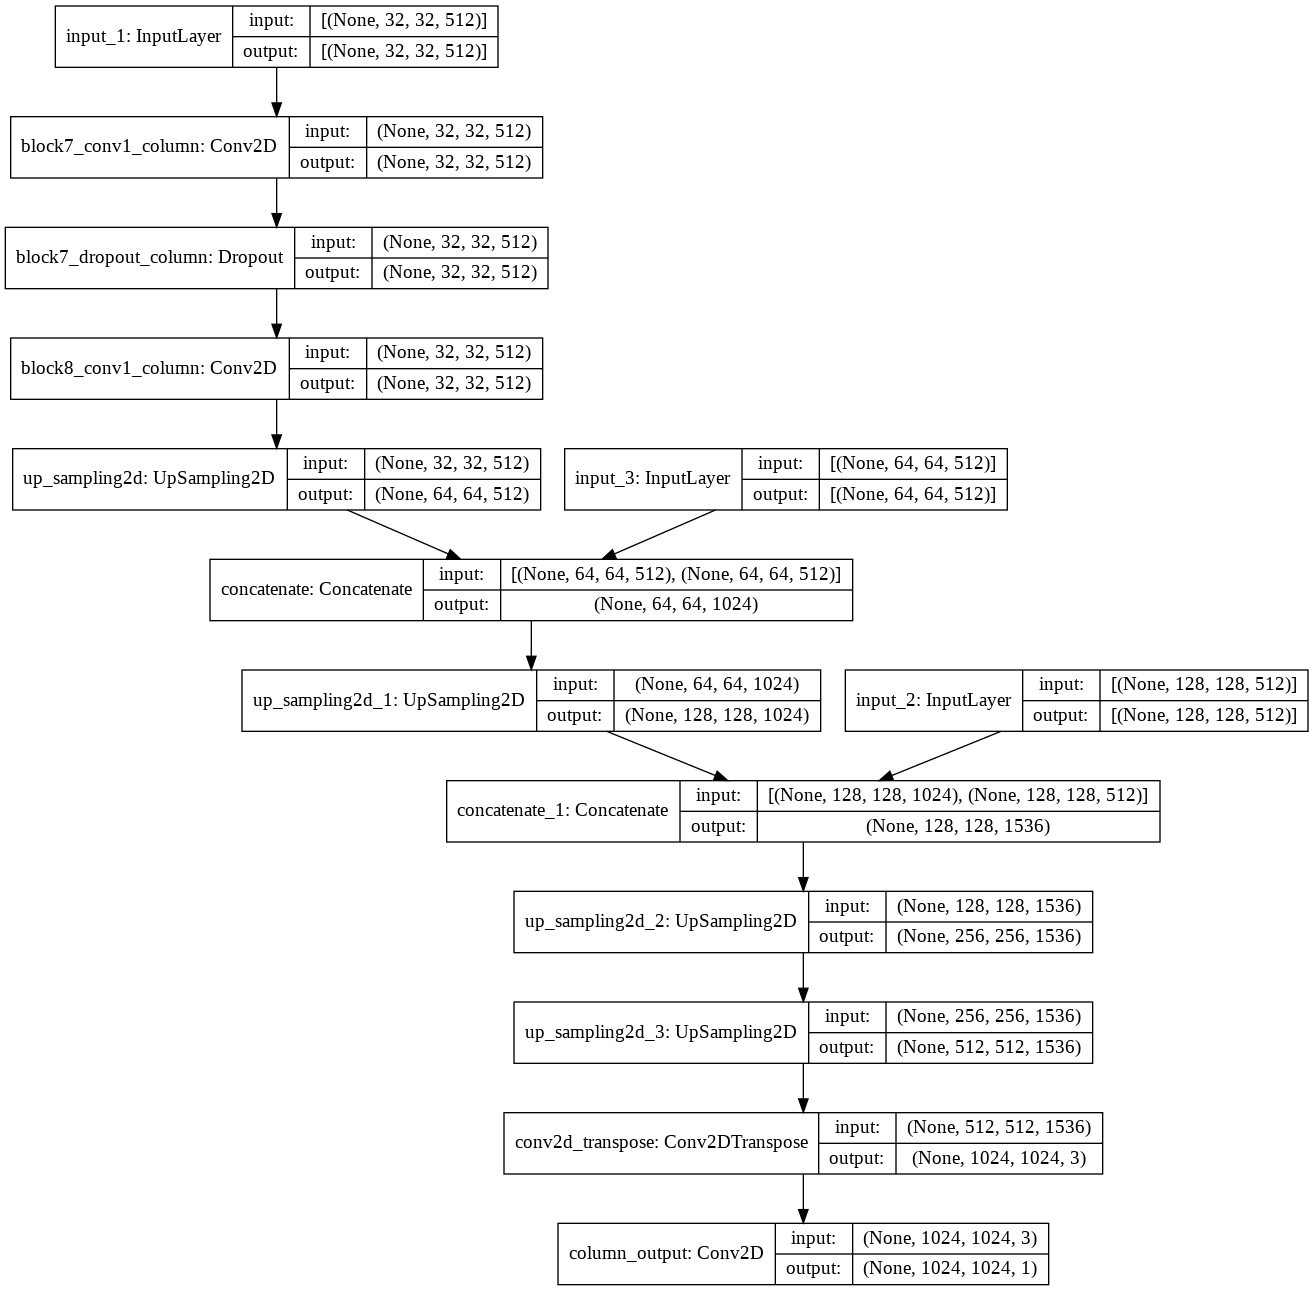

In [ ]:
## This is column decoder branch
class column_decoder(Model) :
    def __init__(self) :
        super().__init__()
        self.conv1 = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')
        self.drop1 = Dropout(0.8, name='block7_dropout_column')
        self.conv2 = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')
        self.up1 = UpSampling2D(size=(2, 2))
        self.concat1 = Concatenate()
        self.up2 = UpSampling2D(size=(2,2))  
        self.concat2 = Concatenate()
        self.up3 = UpSampling2D(size=(2,2))
        self.up4 = UpSampling2D(size=(2,2))
        #self.filter_list = [100]
        #self.conv1_series = []
        #for filter in self.filter_list :
        #    self.conv1_series.append(Conv2D(filter, (1, 1), activation = 'relu'))
        self.conv_transpose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same') 
        self.column_final = Conv2D(1, (1, 1), activation = 'sigmoid', name = 'column_output') 

    def call(self, inps, pool3, pool4) :
        x = self.conv1(inps)
 
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.up1(x)
        concatenated = self.concat1([x, pool4])
        x = self.up2(concatenated)
        concatenated = self.concat2([x, pool3])
        x = self.up3(concatenated)
        x = self.up4(x)
        #for layerr in self.conv1_series :
        #    x = layerr(x)
        x = self.conv_transpose(x)
        x = self.column_final(x)
        return x
    
    def build_graph(self) :
        inp1 = Input(shape = (32, 32, 512))
        inp2 = Input(shape = (128, 128, 512))
        inp3 = Input(shape = (64, 64, 512))
        return Model(inputs = [inp1, inp2, inp3], outputs = self.call(inp1, inp2, inp3))

tf.keras.utils.plot_model(column_decoder().build_graph(), show_shapes = True)

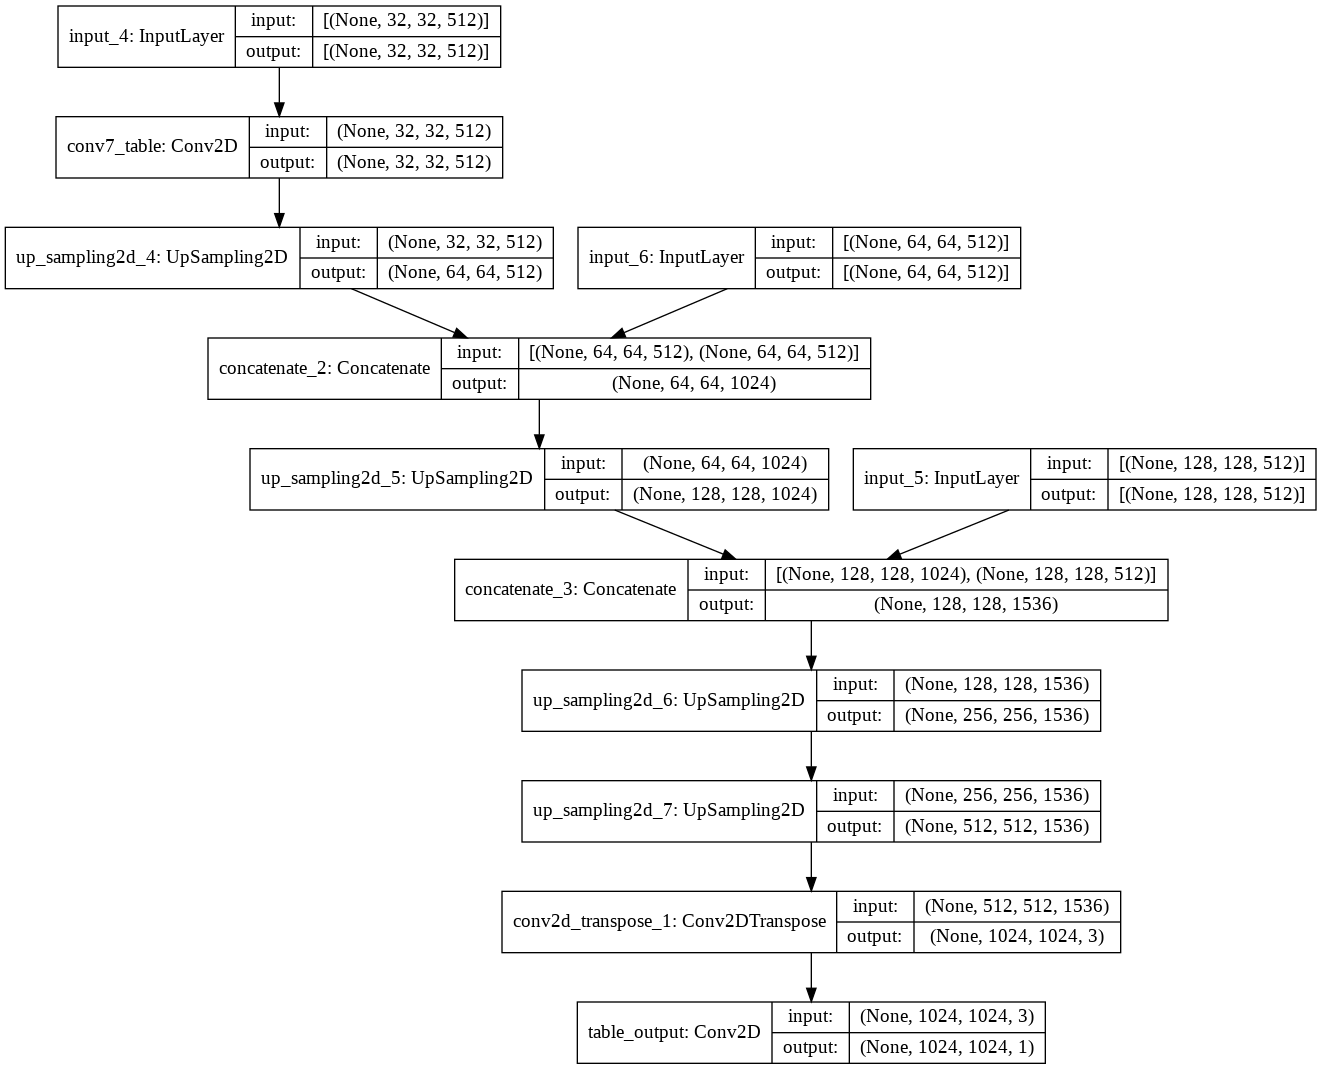

In [ ]:
## This is Table Decoder Branch.

class table_decoder(Model) :
    def __init__(self) :
        super().__init__()
        self.conv1 = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')
        self.up1 = UpSampling2D(size=(2, 2))
        self.concat1 = Concatenate()
        self.up2 = UpSampling2D(size=(2,2)) 
        self.concat2 = Concatenate()
        self.up3 = UpSampling2D(size=(2,2))
        self.up4 = UpSampling2D(size=(2,2))
        #self.filter_list = [100]
        #self.conv1_series = []
        #for filter in self.filter_list :
        #    self.conv1_series.append(Conv2D(filter, (1, 1), activation = 'relu'))
        self.conv_transpose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same') 
        self.table_final = Conv2D(1, (1, 1), activation = 'sigmoid', name = 'table_output')     

    def call(self, inps, pool3, pool4) :
        x = self.conv1(inps)
        x = self.up1(x)
        concatenated = self.concat1([x, pool4])
        x = self.up2(concatenated)
        concatenated = self.concat2([x, pool3])
        x = self.up3(concatenated)
        x = self.up4(x)
        #for layerr in self.conv1_series :
        #    x = layerr(x)
        x = self.conv_transpose(x)
        x = self.table_final(x)
        return x

    def build_graph(self) :
        inp1 = Input(shape = (32, 32, 512))
        inp2 = Input(shape = (128, 128, 512))
        inp3 = Input(shape = (64, 64, 512))
        return Model(inputs = [inp1, inp2, inp3], outputs = self.call(inp1, inp2, inp3))

tf.keras.utils.plot_model(table_decoder().build_graph(), show_shapes = True)

80142336/80134624 [==============================] - 2s 0us/step


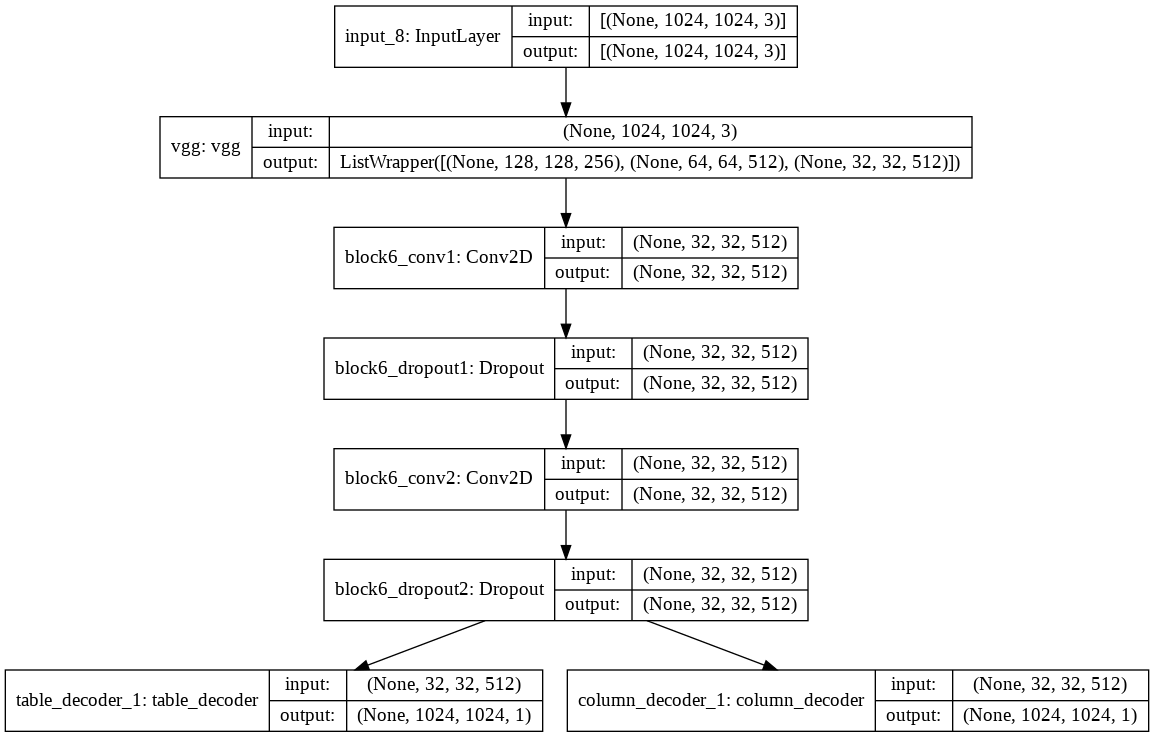

In [ ]:
## This is the final Model

class TableNet(Model) :
    def __init__(self) :
        super().__init__()
        self.vgg_obj = vgg()
        self.col_mask = column_decoder()
        self.table_mask = table_decoder()
        self.conv1 = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')
        self.drop1 = Dropout(0.8, name='block6_dropout1')
        self.conv2 = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')
        self.drop2 = Dropout(0.8, name = 'block6_dropout2')
        
    def call(self, data) :
        inps = data
        vgg_output = self.vgg_obj(inps)
        x = self.conv1(vgg_output[2])
        x = self.drop1(x)
        x = self.conv2(x)
        x = self.drop2(x)
        table_out = self.table_mask(x, vgg_output[0], vgg_output[1])
        column_out = self.col_mask(x, vgg_output[0], vgg_output[1])
        return table_out, column_out
        #return table_out

    def build_graph(self):
        x = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))
        return Model(inputs=[x], outputs=self.call(x))

final_model = TableNet()
tf.keras.utils.plot_model(final_model.build_graph(), show_shapes = True)

In [ ]:
## F1 Score is used to measure the performance the model

def f1score(y_true, y_pred) :
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_pred = y_pred > 0.5
    return tf.py_function(func = f1_score, inp = [y_true, y_pred], Tout = tf.float32)

losses = {"output_1": sm.losses.dice_loss, "output_2": sm.losses.dice_loss}

K.clear_session()
loss_weights = {"output_1": 1.0, "output_2": 1.0}
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss = losses, \
              metrics = [f1score], \
              loss_weights = loss_weights)

In [ ]:
final_model.fit(train_dataloader, validation_data = test_dataloader, epochs = 25, validation_steps = 25, \
                callbacks = tf.keras.callbacks.ModelCheckpoint('./drive/MyDrive/best_tablenet_model.h5', save_weights_only=True, save_best_only=True, mode='auto'))

Epoch 1/25
209/209 [==============================] - 531s 3s/step - loss: 0.6277 - output_1_loss: 0.2778 - output_2_loss: 0.3500 - output_1_f1score: 0.7222 - output_2_f1score: 0.6501 - val_loss: 0.5953 - val_output_1_loss: 0.2594 - val_output_2_loss: 0.3359 - val_output_1_f1score: 0.7406 - val_output_2_f1score: 0.6642
Epoch 2/25
209/209 [==============================] - 525s 3s/step - loss: 0.6192 - output_1_loss: 0.2758 - output_2_loss: 0.3434 - output_1_f1score: 0.7242 - output_2_f1score: 0.6566 - val_loss: 0.5877 - val_output_1_loss: 0.2594 - val_output_2_loss: 0.3283 - val_output_1_f1score: 0.7406 - val_output_2_f1score: 0.6717
Epoch 3/25
209/209 [==============================] - 528s 3s/step - loss: 0.6354 - output_1_loss: 0.2821 - output_2_loss: 0.3532 - output_1_f1score: 0.7179 - output_2_f1score: 0.6468 - val_loss: 0.5955 - val_output_1_loss: 0.2560 - val_output_2_loss: 0.3394 - val_output_1_f1score: 0.7440 - val_output_2_f1score: 0.6606
Epoch 4/25
209/209 [=================

In [ ]:
final_model.fit(train_dataloader, validation_data = test_dataloader, epochs = 1, steps_per_epoch = 2, validation_steps = 2, \
                callbacks = tf.keras.callbacks.ModelCheckpoint('./drive/MyDrive/best_tablenet_modelX.h5', save_weights_only=True, save_best_only=True, mode='auto'))
final_model.load_weights('./drive/MyDrive/best_tablenet_model.h5')

2/2 [==============================] - 36s 11s/step - loss: 1.3944 - output_1_loss: 0.6183 - output_2_loss: 0.7760 - output_1_f1score: 0.3816 - output_2_f1score: 0.2240 - val_loss: 1.2877 - val_output_1_loss: 0.5931 - val_output_2_loss: 0.6947 - val_output_1_f1score: 0.4070 - val_output_2_f1score: 0.3053


The 0.5 threshold does not always work so we decided to find out optimum threshold by taking different values of START and LIMIT optimum thresholds are decided. This approach is used because getting F1 Score of 2 Crore data points was taking too much time so we took subset of datapoints and decided the threshold. We are actually inconclusive about the threshold because for some image smaller thresholds are working and for some images bigger thresholds seems to work well
Any way we kept higher thresholds such as 0.95 and 0.9 because we have lots of false positives.

In [ ]:
%%time
col_predicted_list = []
col_actual_list = []
tab_predicted_list = []
tab_actual_list = []

new_dataset = dataset(train_df)
new_dataloader = dataloader(new_dataset, BATCH_SIZE)

for j in range(10) :
    image_batch = new_dataloader[j]
    model_out = final_model.predict(image_batch[0])
    tab_actual_list.extend(image_batch[1][0].flatten())
    col_actual_list.extend(image_batch[1][1].flatten())
    tab_predicted_list.extend(model_out[0].flatten())
    col_predicted_list.extend(model_out[1].flatten())  
    del image_batch
    del model_out  

CPU times: user 9.82 s, sys: 1.95 s, total: 11.8 s
Wall time: 12.1 s


In [ ]:
print(len(tab_actual_list), len(tab_predicted_list), len(col_predicted_list), len(col_actual_list))

20971520 20971520 20971520 20971520


In [ ]:
%%time
import functools
def decide_threshold(actual, pred) :
    opt_threshold = -1
    opt_score = -1
    for thres in set(pred) :
        if thres > 0.6 :
            score = f1_score(actual, pred > thres)
            if score > opt_score :
                opt_score = score 
                opt_threshold = thres
    return opt_score, opt_threshold

START = (1024 * 1024)
LIMIT = (1024 * 1024)

for j in range(1, 10) :
    STARTX = (j * START)
    col_score, threshold_col = decide_threshold(col_actual_list[STARTX : STARTX + LIMIT], col_predicted_list[STARTX : STARTX + LIMIT])
    tab_score, threshold_tab = decide_threshold(tab_actual_list[STARTX : STARTX + LIMIT], tab_predicted_list[STARTX : STARTX + LIMIT])
    print(col_score, threshold_col, tab_score, threshold_tab)

0.6185265682380274 0.99982256 0.7478001019045127 0.64144397
0.6794079649497277 0.6323858 0.8078247121957737 0.61244065
0.5688860548736207 0.6086268 0.727908886820347 0.6051187
0.7937050905778767 0.99999845 0.8993509124800153 0.9999999
0.19045857988165682 0.7749879 0.2649974097737869 0.72599965
0.7323083652269 0.9999999 0.884319034756223 0.9999999
0.6825741980999874 0.9999999 0.7003277217729375 0.9999999
0.809509352887602 0.9999999 0.9084651539442222 0.9999999
0.5111218528595302 0.69470286 0.7064959527731838 0.60783005
CPU times: user 57min 18s, sys: 56.1 s, total: 58min 14s
Wall time: 58min 1s


Due to lack of RAM and minimum amount of time my model is able to achieve following results
<ul>
<li>Train F1 Score Table = 0.73 </li>
<li>Test F1 Score Table = 0.74 </li>
<li>Train F1 Score Column = 0.67 </li>
<li>Test F1 Score Column = 0.68 </li>
</ul>

There are lots of things which are missing here I wanted to add few conv layers with kernel size (1, 1) before applying transposed convolution in column and table decoder branch but due to RAM I was not able to apply this. <br>

Trying unfreezing the VGG layers after warming up new layers, increasing the batch size could have improved the score. <br>

I am sure that proper training will achieve good F1-Score for both Column and Table branches.

By analysing results we have observed that for a given image, the table masks for different tables are quite well separated but there are some disontinuities in the table mask that is sometimes in the table mask some pixels though belongs to table are marked as background pixel. We can fix this by applying the Dilation operation. 

We either dont have proper column mask or the column mask is getting connected with adjacent column mask. To fix this we probably want to add Erosion operation. Lets try this and see if this improves the resuts.



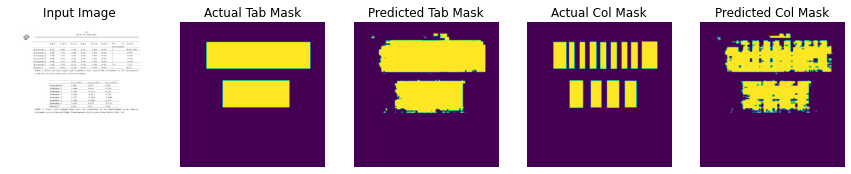

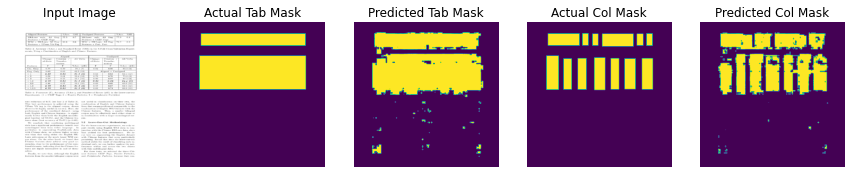

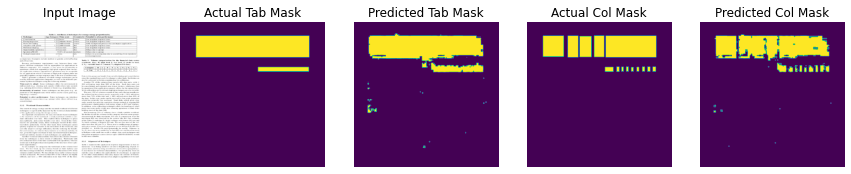

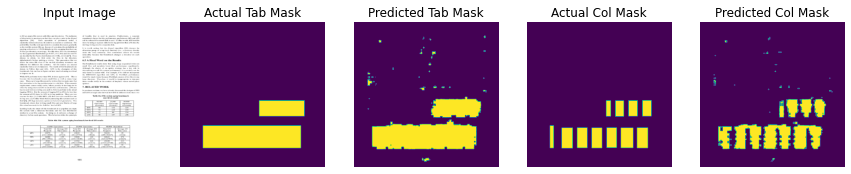

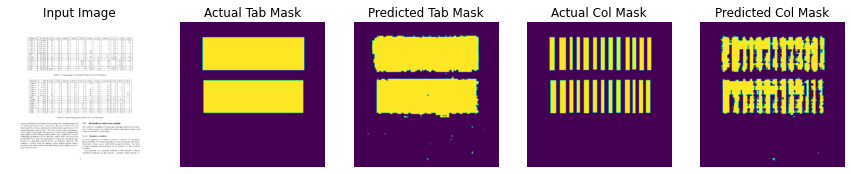

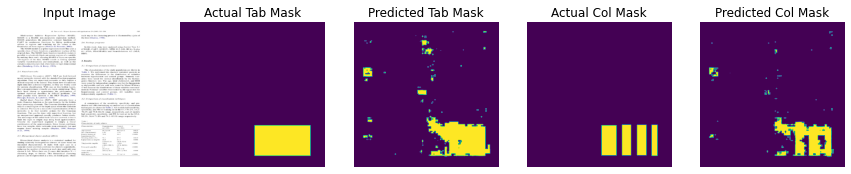

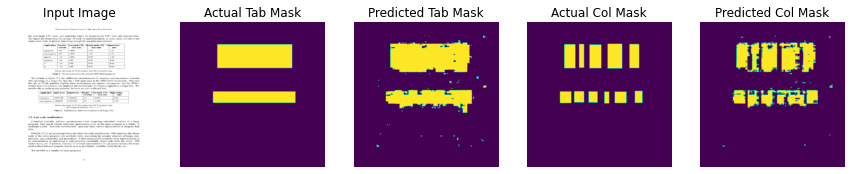

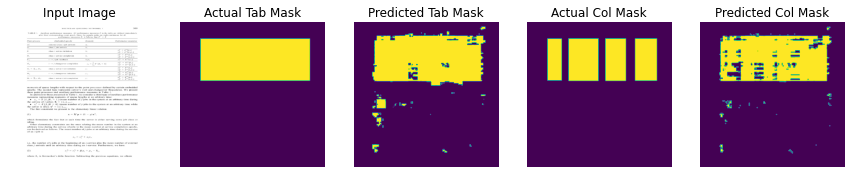

In [ ]:
TAB_THRES = 0.95
COL_THRES = 0.9
new_dataset = dataset(train_df)
new_dataloader = dataloader(new_dataset, BATCH_SIZE)

def display(display_list, title = ['Input Image', 'Actual Tab Mask', 'Predicted Tab Mask', 'Actual Col Mask', 'Predicted Col Mask']):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for j in [20, 22, 28, 32] :
    image_batch = new_dataloader[j]
    model_out = final_model.predict(image_batch[0])
    for k in [0, 1] :
        pred_tab = np.array(model_out[0][k] > TAB_THRES, dtype = np.uint8)
        pred_col = np.array(model_out[1][k] > COL_THRES, dtype = np.uint8)
        pred_tab = np.expand_dims(cv2.dilate(pred_tab, kernel = (3, 3)), axis = -1)
        pred_col = np.expand_dims(cv2.erode(pred_col, kernel = (5, 5)), axis = -1)
        display([image_batch[0][k], image_batch[1][0][k] * 255, pred_tab * 255, image_batch[1][1][k] * 255, pred_col * 255])


Minimum area of table we are assuming to be more than 50000 pixels. To get the each table's mask separately from other tables we are applying connected component function on produced table mask and we are taking only those connected components who are having area greater than 50000 pixels.

1024 41


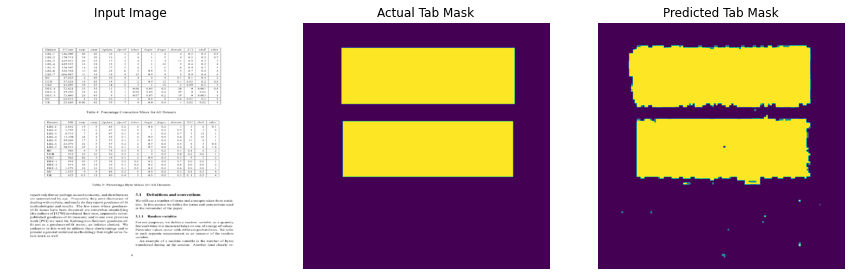

Area =  182956
(1024, 1024, 1) 128 97 881 354


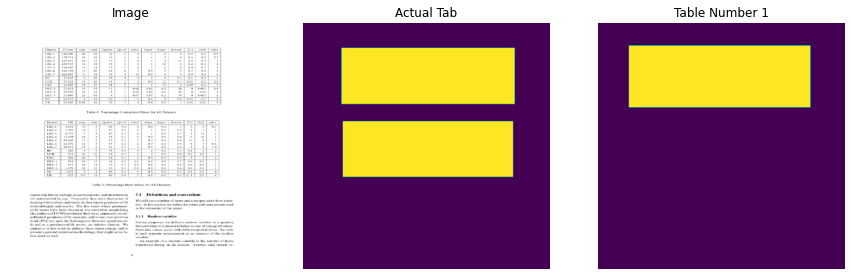

Area =  175505
(1024, 1024, 1) 160 385 880 674


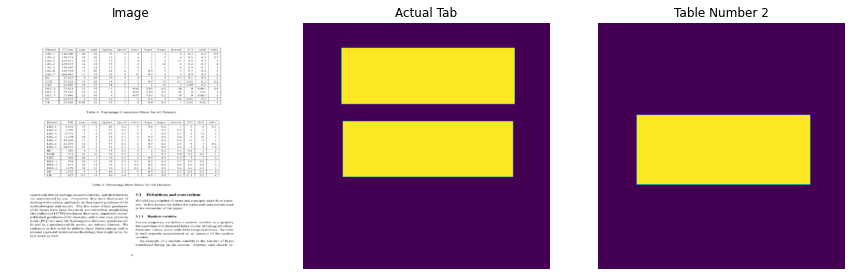

In [ ]:
image_batch = new_dataloader[28]
k = 0
model_out = final_model.predict(image_batch[0])
pred_tab = np.array(model_out[0][k] > TAB_THRES, dtype = np.uint8)
pred_col = np.array(model_out[1][k] > COL_THRES, dtype = np.uint8)
pred_tab = np.expand_dims(cv2.dilate(pred_tab, kernel = (3, 3)), axis = -1)
pred_col = np.expand_dims(cv2.erode(pred_col, kernel = (5, 5)), axis = -1)
image = image_batch[0][0]
actual_tab = np.array(image_batch[1][0][0], np.uint8)
actual_col = np.array(image_batch[1][1][0], np.uint8)
connectivity = 16

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(pred_tab, connectivity)
print(len(labels), num_labels)
display([image, actual_tab * 255, pred_tab * 255])
count = 1
for i in range(1, num_labels) :
    if stats[i][4] > 50000 :
        print('Area = ', stats[i][4])
        modified_tab = np.zeros(shape = (1024, 1024, 1), dtype = np.uint8)
        xmin = stats[i][0]
        ymin = stats[i][1]
        xmax = xmin + stats[i][2]
        ymax = ymin + stats[i][3]
        print(modified_tab.shape, xmin, ymin, xmax, ymax)
        modified_tab[ymin : ymax, xmin : xmax, :] = 1
        display([image, actual_tab * 255, modified_tab * 255], title = ['Image', 'Actual Tab', 'Table Number {}'.format(count)])
        count += 1

Now we have seperate masks for each table the same algo can be applied to get proper column mask. Below algorithm can be applied to get each individual cell/entry. Once we know the area of an entry we can crop it send the cropped image to pytesseract get the text inside the cell. The text values of each cell can be arranged to create csv files.

One can implement the below algorithm to get the individual cell/entry and corresponding text. It works only with tables whose cell entries are marked using lines.

In [ ]:
## Algorithm to get Location/Area of individual cell of table 

table_list = [] # By applying above algorithm (Connected Component) we will get individual table masks store them in table_list
## proper column mask for all columns of all tables present in the image. 
## The column mask will be modified by using connected component analysis
col_mask = ['mask']

for table in table_list : ## Process individual tables
    cur_table_col_mask = table * col_mask ## To get columns of current table
    column_list = get_connected_componenet(cur_table_col_mask) ## pass current_table_col_mask to connected component analysis and get column mask list    
    for col in column_list : ## process individual column
        xmin, xmax, y_min is already available using current columns mask ## xmin, xmax is width of current column and ymin is start of column in vertical direction
        #To find out ymax we will move vertically in each column to detect the line which separate the cell/entry
        ##The line_list is the list of ymaxes that we will get by moving vertically in the column mask 
        ## and is equal to number of cells in the current column
        line_list = get_lines(col, original_image)
        for ymax in line_list :
            cell_cordinates = [xmin, ymin, xmax, ymax] #crop the orginal_image using cell_coordinates and pass it to tesseract
            ## update ymin
            ymin = ymax


## T-YOLO3

There are lots of rule we must create for other kind of tables (Table with no horizontle line separating the rows) which is hectic and error prone process and with the change of table structure rules to extract cell/entry from the table must also be changed.

Atleast I have came across the tables where in we dont have proper columns or the column is in dicontinued fashion and for these kind of tables TableNet architecture wont work well. 

To deal with all of these problems I am working to design Table-YOLO3 or T-YOLO3 State Of The Art deep learning architecture based on YOLO-3 object detection model which is kind of advanced architecture which will help us creating CSV file from pdfs or images. I will soon share its details. 